<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/homework/hw3/GM/Tema_3_Neural_Style_Transfer_Skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 3 - A new Picasso is in town
## Neural Style Transfer
### Autori: 
* George Muraru

## 1. Scopul temei


Tema are ca scop folosirea rețelelor neurale convoluționale pentru a **modifica imagini prin preluarea stilului** de la o alta imagine.
Este o tehnica prin care se genereaza o noua imaginie folosind o imagine de baza (eng. *content image*) și o imagine a cărui stil (eng. *style image*) dorim să îl transferăm la imaginea de bază (rezultat numit în temă *generated image*). 


![result](https://raw.githubusercontent.com/cs-pub-ro/ML/master/homework/hw3/GM/img/colab/result.svg)



### 2. High Level Architecture

<img src="https://miro.medium.com/max/1294/1*ZgW520SZr1QkGoFd3xqYMw.jpeg" alt="High Level Architecture" width=1250/>

Reference: [Intuitive guide to neural style transfer](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee)
 

### Descărcare bibloteci/fișiere de care vom avea nevoie

In [0]:
!pip install torch
!pip install torchvision
!pip install pillow
!pip install kornia


!wget -q -O cat.png https://github.com/cs-pub-ro/ML/blob/master/homework/hw3/GM/img/content/cat.png?raw=true

!wget -q -O the_scream.jpg https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg
!wget -q -O starry_night.jpg https://github.com/cs-pub-ro/ML/blob/master/homework/hw3/GM/img/style/starry_night.jpg?raw=true
!wget -q -O ./content_folder/the_scream.jpg https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg
!wget -q -O face_of_war.jpg https://upload.wikimedia.org/wikipedia/en/a/a9/The_Face_of_War.jpg
!wget -q -O tsunami.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/2880px-Tsunami_by_hokusai_19th_century.jpg
!wget -q -O weeping_woman.jpg https://upload.wikimedia.org/wikipedia/en/1/14/Picasso_The_Weeping_Woman_Tate_identifier_T05010_10.jpg



./content2112_folder/the_scream.jpg: No such file or directory
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/utils/misc.py", line 19, in <module>
    from pip._vendor import pkg_resources
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 84, in <module>
    __import__('pip._vendor.packaging.requirements')
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/packaging/requirements.py", line 60, in <module>
    MARKER_EXPR = originalTextFor(MARKER_EXPR())("marker")
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pyparsing

KeyboardInterrupt: ignored

### Biblioteci de care vom avea nevoie

In [0]:
import torch
import torch.optim as optim
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import kornia

### Hiper-parametrii



In [0]:
CUDA = True #@param {type: "boolean"}
ALPHA = 1 #@param {type: "slider", min: 0, max: 1e2, step: 1}
BETA = 1e4 #@param {type: "slider", min: 0, max: 1e9, step: 1}
IMG_SIZE = 512 #@param [128, 256, 512]
STYLE_IMAGE = "starry_night.jpg" #@param ["abstract.jpeg", "colorful.jpg", "picasso.jpg", "starry_night.jpg", "vassily.jpg"]
CONTENT_IMAGE = "cat.png" #@param ["bucharest.jpg", "cat.png", "dancing.jpg", "dog.jpeg", "labrador.jpg", "zurich.jpg"]
START_GENERATED_IMAGE = "CONTENT" #@param ["STYLE", "CONTENT", "RANDOM"]
STYLE_IMAGE = "./style_folder/" + STYLE_IMAGE
CONTENT_IMAGE = "./content_folder/" + CONTENT_IMAGE

if not os.path.exists("./results"):
  os.mkdir("results")

if not os.path.exists("./content_folder"):
  os.mkdir("content_folder")

if not os.path.exists("./style_folder"):
  os.mkdir("style_folder")

### Model

Pentru a putea extrage **stilul** și **conținutul** unei imagini ne vom folosi de o rețea neurală deja antrenată.

Noțiunea de a folosi o rețea pre-antrenată pentru a rezolva un alt task poartă denumirea de [Transfer Learning](https://ruder.io/transfer-learning/).

Într-o rețea convoluțională primele layere extrag feature-uri low-level (acestea le vom folosi să extragem **stilul**), iar layerele "mai apropiate de output" ne vor furniza **conținutul**.

Pentru acest lucru vom folosi o rețea VGGNet, mai specific VGG19.

![VGG19](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

Parametrii rețelei vor trebui să ramână fixați la valorile inițiale pe parcursul rulării. Din acest motiv va trebui să nu facem update parametrilor în timpul optimizării.

Din rețeaua mai sus specificată vom folosi anumite layere (descrise mai jos) pentru a extrage feature-urile care ne interesează pentru cele 2 loss-uri.

In [0]:
# TODO 1.0: Load model and move it to CUDA if selected

model_nn_normal = models.vgg19(pretrained=True).features.eval()
model_nn_bonus = models.vgg19(pretrained=True).features.eval()
#model_nn_bonus = models.inception_v3(pretrained=True)

if CUDA:
  model_nn_normal = model_nn_normal.cuda()
  model_nn_bonus = model_nn_bonus.cuda() 
# TODO 1.1: Freeze the parameters for the model

for child in list(model_nn_normal.children()):
  for param in child.parameters():
    param.requires_grad = False
  
for child in list(model_nn_bonus.children()):
  for param in child.parameters():
    param.requires_grad = False

### Imagini folosite

Problema pe care dorim să o rezolvăm este de a genera **conținut** apropiat de o imagine de referință, conținut al cărui **stil** trebuie să fie apropiat de o altă imaginie.

Pentru acest lucru ne vom defini 3 imagini:
1. Imaginea a cărui conținut dorim să il copiem - notată $I_{C}$
2. Imaginea a cărui stil dorim să îl copiem - notată $I_{S}$
3. Imaginea generată (aceasta va avea inițial valori generate random) - notată $I_{G}$
  * această imagine va fi modificată în timpul optimizării

Intuitiv, soluția ar trebui să presupună rezolvarea a 2 probleme separate:
* Generare de **conținut**
* Generare de **stil**

Pentru a cunatifica cât de aproape suntem de o soluție (o imaginie generată perfect) vom folosi 2 loss-uri, specificate în continuare.

### Lucrul cu imagini

Un prim pas care trebuie realizat este deschiderea și afișarea unei imagini.
Ar trebui ca să avem 2 imagini descărcate: *starry_night.jpeg* și *cat.png*.

De asemnea, deoarece folosim o rețea neurală predefinită, va trebui să modificăm inputul astfel încât acesta să corespundă inputului așteptat de către rețea.



In [0]:
def get_image(img_path):
    """ Get an image ready to be run through the pretrained neural network

    Args:
        img_path (string): the path to the image

    Returns:
        A tensor with shape (B, H, W, C) where:
        * B - represents the batch size (SHOULD BE 1)
        * C - number of channels (3 - RGB)
        * H - the height of the image (it should be IMG_SIZE after transformation)
        * W - the width of the image (it should be IMG_SIZE after transformation)
    """

    '''
        TODO 1.0 - Use the transforms from torch library to do the following ops:
        * Resize to an image of (IMG_SIZE, IMG_SIZE)
        * Transform to a tensor (since the PIL library works with numpy arrays)
        * The tensor should have values in the range [0, 1]
        * Normalize using :
            * mean = [0.485, 0.456, 0.406]
            * std = [0.229, 0.224, 0.225]
            (because the pretrained model was trained using those values)
            (Formula: new_img = (img - mean) / std)
    '''

    # TODO 1.1: Add a size 1 dimension for the batch
    img = Image.open(img_path).convert('RGB')

    transform = transforms.Compose(
    [transforms.Resize([IMG_SIZE, IMG_SIZE]),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
    img = transform(img)
    
    # Hint: unsqueeze
    img = img.unsqueeze(0)
    
    # TODO 1.2: Move to cuda if support is enabled
    if CUDA:
      img = img.cuda()
    
    return img


def show_imgs(*imgs, folder_name=None, name_save=None):
    """ Plot images received as parameters (on the same row with different
        collumn)

    Args:
        imgs (tensors representing the images): images to plot
    """
    plt.figure(figsize=(15,15))

    # TODO 2.0:
    # Define the inverse of the `normalize` and `toTensor` operations performed
    # in the `get_image` function

    for i, img in enumerate(imgs):

        # TODO 2.1: Detach, clone and move to CPU (the image)
        img_cpu = img.detach().clone().cpu()

        # TODO 2.2: Remove the `batch` dimension (the first one)
        # Hint: squeeze
        img_cpu = img_cpu.squeeze(0)
        #print(img_cpu.shape)

        # TODO 2.3: Apply the inverse of the `normalize` operation
        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )

        # inverse of normalize
        img_cpu = inv_normalize(img_cpu)
        img_cpu.data.clamp_(0, 1)

        # inverse of toTensor
        img_cpu = transforms.ToPILImage()(img_cpu).convert("RGB")
        #print(img_cpu)
        
        plt.subplot(1, 2, i+1)

        # Remove the x, y coordinates from the plot and show the image

        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_cpu)

    if folder_name and name_save is not None and name_save != "":
      if not os.path.exists("./results/" + folder_name):
        os.mkdir("./results/" + folder_name)
      plt.savefig("./results/" + folder_name + "/" + name_save)
    plt.show()

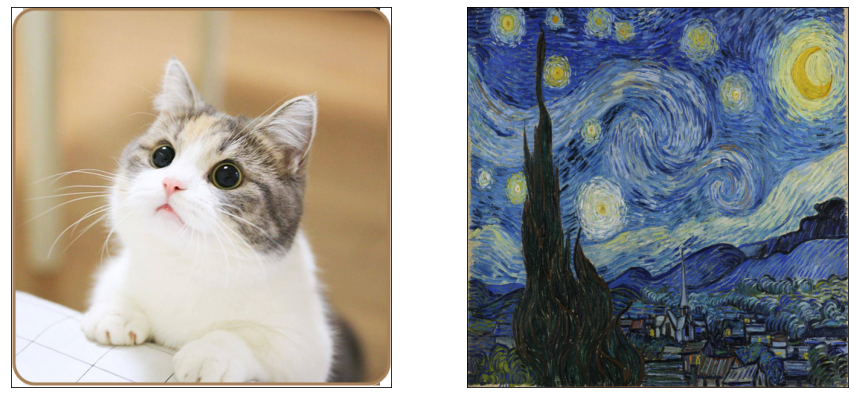

In [0]:
# Testing Area
img_content = get_image(CONTENT_IMAGE)
img_style = get_image(STYLE_IMAGE)
assert isinstance(img_content, torch.Tensor)
assert img_content.shape == (1, 3, IMG_SIZE, IMG_SIZE)
assert not CUDA ^ img_content.is_cuda

show_imgs(img_content, img_style)

### Content Loss

Loss-ul aceasta are rolul de a ne ajuta să recreăm **conținutul** unei imagini, el însemnând cât de mult diferă imaginea generată față de imaginea al cârui conținut dorim să îl "copiem".

După cum s-a menționat mai sus, activările (eng. activation map/feature map) straturilor convoluționale aflate spre finalul rețelei ne oferă informații mai high-level despre o imagine.

Putem folosi aceste activări pentru a calcula **content loss**:

$$
J_{content} = \frac{1}{N}\sum_{i,j}(a_{generated}^{i,j} - a_{content}^{i,j})^2
$$

Unde:
* $N$ - numărul de elemente din feature map-ul specific
* $a_{generate}$ - matricea activărilor specifice $I_{G}$
* $a_{content}$ - matricea activărilor specifice $I_{C}$

Pentru a obține feature map-ul se va face un **feedforward** cu imaginile:
* $I_{G}$ pentru a obține $a_{generated}$
* $I_{C}$ pentru a obține $a_{content}$

Stratul de convoluție a carui activări ne interesează este **conv4_2** (vedeți imaginea de mai sus de la VGG19).

In [0]:
import copy
def run_feedforward(img, activations_list_names, model):
    ''' Do a feedforward step using the image given as parameter and keep track
    of the activations

    Args:
        img (Tensor): the image used for feedforward
        model (Model): the pretrained (and frozen) model

    Returns:
        A list containing the activations generated by passing the image through
    the model
    '''
    activations = {}
    
    # TODO 3.0: Compute the activations (for each layer of the model) and
    # store them in the list
    
    # am modificat aici azi
    #image = img.clone()
    image = img
    if CUDA and not image.is_cuda:
      image = image.cuda()
    if CUDA:
      model = model.cuda()
    
    conv_no, curr_idx = 1, 0
    basic_block_no, curr_idx_basic_block = 1, 1
    for child in list(copy.deepcopy(model).children()):
      if isinstance(child, (torch.nn.Conv2d, torch.nn.ReLU, torch.nn.BatchNorm2d, torch.nn.MaxPool2d)):
        image = child(image)
        if isinstance(child, torch.nn.Conv2d):
          curr_idx += 1
          name = "conv{}_{}".format(conv_no, curr_idx)
          
        elif isinstance(child, torch.nn.ReLU):
          name = "relu{}_{}".format(conv_no, curr_idx)
          
        elif isinstance(child, torch.nn.BatchNorm2d):
          name = "bn{}_{}".format(conv_no, curr_idx)
          
        elif isinstance(child, torch.nn.MaxPool2d):
          name = "maxPool{}_1".format(conv_no)
          conv_no += 1
          curr_idx = 0
        
        if name in activations_list_names:
          activations[name] = image
          
      else:
        print(child)
        '''
        for curr_idx_basic_block, ch in enumerate(child.children()):
          relu_no = 1
          for l in ch.children():
            image = ch(image)
            name = "bb{}_{}_relu_{}".format(basic_block_no, curr_idx_basic_block + 1, relu_no)
            print(name)
            if isinstance(l, torch.nn.ReLU):
              relu_no += 1
            if name in activations_list_names:
              activations[name] = image 
        basic_block_no += 1
        '''
    
    #for x in activations:
    #  print(x)
    #print("-----------")
    return activations


def get_content_loss(features_content, features_generated, type="normal"):
    ''' Get the Content Loss

    Args:
        features_content ([Tensor]): the activations for I_C
        features_generated ([Tensor]): the activations for I_G
    Returns:
        loss (double) - the computed loss for the content
    '''
    # TODO 4.0: Compute the content loss
    #print(features_content.shape, features_generated.shape)
    assert features_content.shape == features_generated.shape
    
    if CUDA and not features_content.is_cuda:
      features_content = features_content.cuda()
    if CUDA and not features_generated.is_cuda:
      features_generated = features_generated.cuda()
    
    #return F.mse_loss(features_content.detach(), features_generated)
    
    if type == "normal":
      return F.mse_loss(features_content.detach(), features_generated)
    else:
      return F.l1_loss(features_content.detach(), features_generated)


### Style Loss



#### **Gram Matrix (Style Matrix)**




Pentru a calcula *style loss-ul* va trebui să folosim *matricea Gram*, calculată pe activările anumitor straturi convoluționale.

Matricea Gram a unui set de vectori V = $(v_0, v_1, v_2,...,v_n)$ este dată de produsul matriceal dintre $V și V^t$.

Această matrice are rolul de a indica care set de feature-uri sunt corelate au valori mari împreună/sunt similare.

Mai multe detalii puteți găsi [aici](https://arxiv.org/pdf/1606.01286.pdf)


#### **Calcul Style Loss**

Style loss-ul va fi reprezentat de *distanța* între matricea gram specifică activărilor pentru imaginea $I_{G}$ și pentru imaginea $I_{S}$.

Pentru activările unui specific layer convoluțional, formula de calcul este următoarea:
$$
    J_{style}^{l} = \frac{1}{4N^2}\sum_{i,j}(G^{i,j}(a_{generated}) - G^{i,j}(a_{style}))^2
$$

Unde:
* l - layer-ul convoluțional pentru care se calculează loss-ul
* $N$ - numărul de elemente din feature map-ul specific
* $a_{generate}$ - matricea activărilor specifice $I_{G}$
* $a_{style}$ - matricea activărilor specifice $I_{style}$

Pentru a obține feature map-ul se va face un **feedforward** cu imaginile:
* $I_{G}$ pentru a obține $a_{generated}$
* $I_{S}$ pentru a obține $a_{style}$

Deoarece activările pentru $I_{G}$ au fost deja calculate de la pasul de *Contnt Loss* acestea **nu vor mai fi recalulate la acest pas**.

Dacă pentru calcularae *content loss-ului* am folosit un singur strat de convoluție, pentru a *captura* stilul unei imagini, vom folosi **mai multe straturi din rețeaua VGG19**, fiecare strat având o anumită pondere la *style loss-ul* final (vedeți cerința de mai jos).

In [0]:
def get_gram_matrix(X):
    ''' Compute the Gram Matrix for the tensor X (the activation map)
    
    Args:
        X (Tensor): Tensor with shape (B, F, H, W)
    
    Returns:
        Tensor representing the Gram Matrix
    '''
    g = None
    b, c, h, w = X.shape


    # TODO 5.0: `g` should be a matrix where:
    # * the rows -- no of channels
    # * the columns -- elements for that specific channel
    # X_new = ...
    a = X.view(b*c, h*w)
    g = torch.mm(a, a.t())
    g = g.div(b*c*h*w)
    
    return g


def get_style_loss(features_style, features_generated, type="normal"):
    ''' Get the Style Loss

    Args:
        features_style ([Tensor]): the activations for I_S
        features_generatd ([Tensor]): the activations for I_G
    Returns:
        loss (double) - the computed loss for the content
    '''

    # TODO 5.1 Compute style loss
    if CUDA and not features_style.is_cuda:
      features_style = features_style.cuda()

    if CUDA and not features_generated.is_cuda:
      features_generated = features_generated.cuda()

    #return F.mse_loss(features_style.detach(), get_gram_matrix(features_generated))
    
    if type == "normal":
      loss = F.mse_loss(features_style.detach(), get_gram_matrix(features_generated))
    else:
      loss = F.l1_loss(features_style.detach(), get_gram_matrix(features_generated))
    return loss

### Generare imagine

Se vor folosi loss-urile definite anterior pentru a calcula un loss total și pentru a genera imaginea finală.

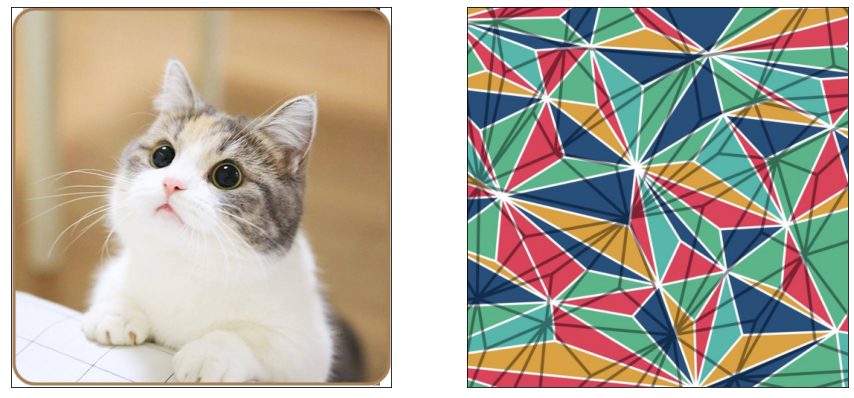

normal_img Style Loss: 205.449462890625 Content Loss: 17.56783676147461 Iteration: 500/ 60000
bonus_img Style Loss: 83.89344787597656 Content Loss: 2.0858378410339355 Iteration: 500/ 60000


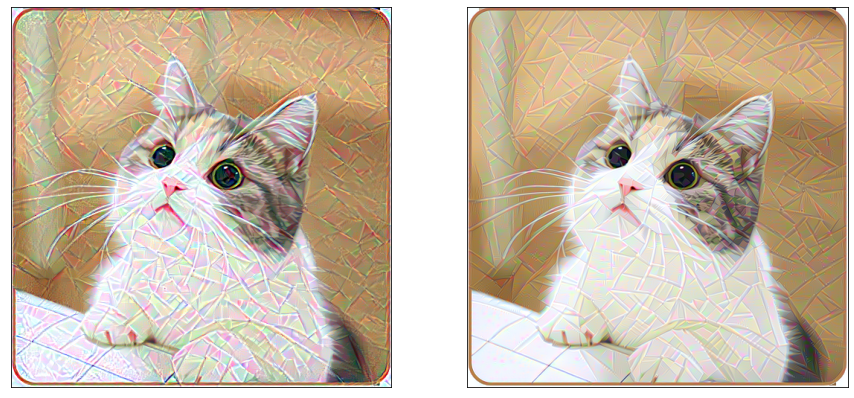

normal_img Style Loss: 59.06058883666992 Content Loss: 17.135713577270508 Iteration: 1000/ 60000
bonus_img Style Loss: 59.13639831542969 Content Loss: 2.371312141418457 Iteration: 1000/ 60000


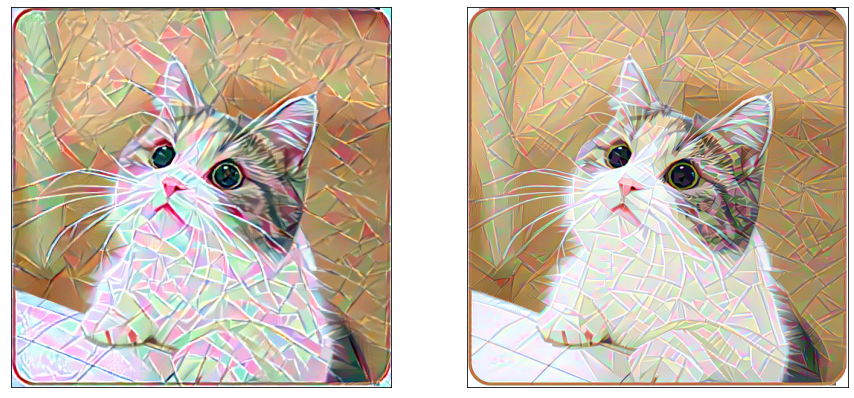

normal_img Style Loss: 36.574440002441406 Content Loss: 16.6680908203125 Iteration: 1500/ 60000
bonus_img Style Loss: 46.611820220947266 Content Loss: 2.4143319129943848 Iteration: 1500/ 60000


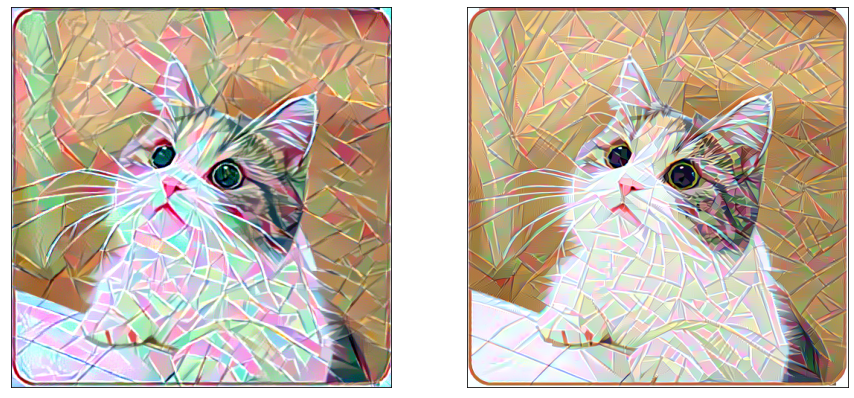

normal_img Style Loss: 20.58348846435547 Content Loss: 15.979911804199219 Iteration: 2000/ 60000
bonus_img Style Loss: 40.08787536621094 Content Loss: 2.5353126525878906 Iteration: 2000/ 60000


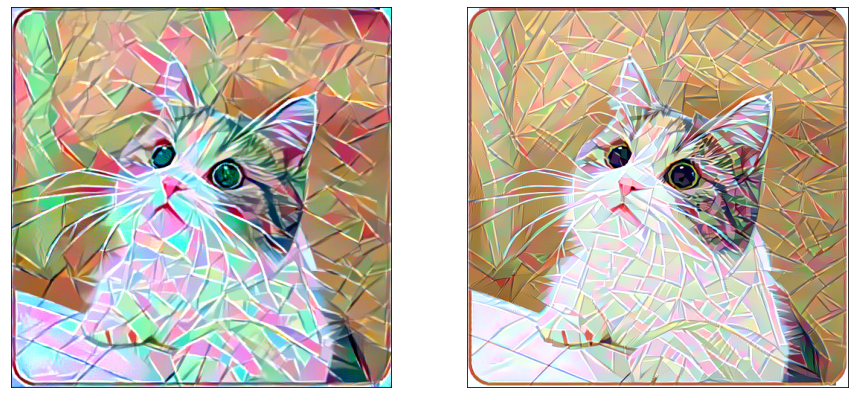

In [0]:
#["abstract.jpeg", "colorful.jpg", "picasso.jpg", "starry_night.jpg", "vassily.jpg"]
#["bucharest.jpg", "cat.png", "dancing.jpg", "dog.jpeg", "labrador.jpg", "zurich.jpg"]
#("tsunami.jpg", "cat.png" ) , ("starry_night.jpg", "cat.png"), 
# next => ("abstract.jpeg", "cat.png"), ("picasso.jpg", "dancing.jpg")
pairs = [("abstract.jpeg", "cat.png")] 
for (STYLE,CONTENT) in pairs:
  STYLE_IMAGE = "./style_folder/" + STYLE
  CONTENT_IMAGE = "./content_folder/" + CONTENT

  content_img = get_image(CONTENT_IMAGE)
  style_img = get_image(STYLE_IMAGE)

  c_image = CONTENT_IMAGE.split(".")[1].split("/")[-1]
  s_image = STYLE_IMAGE.split(".")[1].split("/")[-1]

  show_imgs(content_img, style_img, folder_name="{}_{}".format(c_image, s_image), name_save="init")

  # generated images
  generated_img_normal = content_img.clone()

  if START_GENERATED_IMAGE == "CONTENT":
    generated_img_bonus = content_img.clone()
  elif START_GENERATED_IMAGE == "STYLE":
    generated_img_bonus = style_img.clone()
  elif START_GENERATED_IMAGE == "RANDOM":
    generated_img_bonus = torch.randn((1, 3, IMG_SIZE, IMG_SIZE)) * 0.01
  
  if CUDA:
    generated_img_bonus = generated_img_bonus.cuda()
    generated_img_normal = generated_img_normal.cuda()


  # Need to be set since this image will be updated using the optimizer
  generated_img_normal.requires_grad = True
  generated_img_bonus.requires_grad = True

  # TODO 6.0: Get content and style features

  #normal
  style_layers_weights_normal = {"relu1_1":0.2, "relu2_1":0.2, "relu3_1":0.2, "relu4_1":0.2, "relu5_1":0.2}
  content_layers_weights_normal = {"relu4_2":1.0}
  generated_layers_weights_normal = {}
  for key in style_layers_weights_normal:
    generated_layers_weights_normal[key] = True
  for key in content_layers_weights_normal:
    generated_layers_weights_normal[key] = True

  #bonus
  #pentru vgg19 finetunned
  style_layers_weights_bonus = {"relu1_1":0.2, "relu2_1":0.2, "relu3_1":0.2, "relu4_1":0.2, "relu5_1":0.2}
  content_layers_weights_bonus = {"relu3_1":0.2, "relu3_2":0.7, "relu4_2":0.1}
  #content_layers_weights_bonus = {"relu2_2": 0.05, "relu3_2":0.6, "relu3_4":0.3, "relu4_2":0.05}

  #style_layers_weights_bonus = {"bb1_1_relu_1":0.1, "bb2_1_relu_1":0.15, "bb3_1_relu_1":0.2, "bb4_1_relu_1":0.25, "bb5_1_relu_1":0.25}
  #content_layers_weights_bonus = {"bb3_1_relu_1":0.2, "bb4_1_relu_1":0.3, "bb5_1_relu_1":0.5}

  generated_layers_weights_bonus = {}
  for key in style_layers_weights_bonus:
    generated_layers_weights_bonus[key] = True
  for key in content_layers_weights_bonus:
    generated_layers_weights_bonus[key] = True


  # activations
  content_activations_normal = run_feedforward(content_img, content_layers_weights_normal, model_nn_normal)
  style_activations_normal = run_feedforward(style_img, style_layers_weights_normal, model_nn_normal)

  for name in style_activations_normal:
    activation = style_activations_normal[name]
    style_activations_normal[name] = get_gram_matrix(activation).detach()

  content_activations_bonus = run_feedforward(content_img, content_layers_weights_bonus, model_nn_bonus)
  style_activations_bonus = run_feedforward(style_img, style_layers_weights_bonus, model_nn_bonus)

  for name in style_activations_bonus:
    activation = style_activations_bonus[name]
    style_activations_bonus[name] = get_gram_matrix(activation).detach()

  optimizer1 = optim.LBFGS([generated_img_normal.requires_grad_()])
  #optimizer2 = optim.LBFGS([generated_img_bonus.requires_grad_()])

  #optimizer1 = optim.Adam([generated_img_normal.requires_grad_()])
  optimizer2 = optim.Adam([generated_img_bonus.requires_grad_()])

  steps = 60000
  SHOW_EVERY = 500
  SAVE_EVERY = 2000
  statistics = {"normal_img":{"img":content_img}, "bonus_img":{"img":content_img}}


  mean_unormalize = torch.tensor([-0.485/0.229, -0.456/0.224, -0.406/0.225]).view(-1,1,1).detach()
  std_unormalize = torch.tensor([1/0.229, 1/0.224, 1/0.225]).view(-1,1,1).detach()
  mean_normalize = torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1).detach()
  std_normalize = torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1).detach()
  if CUDA:
    mean_unormalize = mean_unormalize.cuda()
    std_unormalize = std_unormalize.cuda()
    mean_normalize = mean_normalize.cuda()
    std_normalize = std_normalize.cuda()

  transform = torch.nn.Sequential(
        kornia.augmentation.RandomResizedCrop(
        size=(IMG_SIZE, IMG_SIZE), scale=(.97, 1.), ratio=(.97, 1.03)),
        kornia.augmentation.RandomRotation(degrees=1.))
  if CUDA:
    transform = transform.cuda()

  def applyClamp(t):
    #unormalize
    t = (t - mean_unormalize ) / std_unormalize
    
    #clamp
    t.data.clamp_(0,1)

    #normalize
    t = (t - mean_normalize ) / std_normalize


  for i in range(1, steps+1):
      #  ------------------------- closure 1 -------------------------
      def closure():
        # inverse of normalize
        applyClamp(generated_img_normal)
        optimizer1.zero_grad()
        # TODO 6.1: Run feedforward for the generated_img
        generated_activations_normal = run_feedforward(generated_img_normal, generated_layers_weights_normal, model_nn_normal)
        
        # TODO 6.2: Compute content loss
        content_loss = 0
        for layer_name in content_layers_weights_normal:
          weight = content_layers_weights_normal[layer_name]
          aux = get_content_loss(content_activations_normal[layer_name], generated_activations_normal[layer_name])
          content_loss = content_loss + weight * aux 
          
        content_loss = content_loss * 1.0

        # TODO 6.3: Compute style loss
        style_loss = 0
        for layer_name in style_layers_weights_normal:
          weight = style_layers_weights_normal[layer_name]
          s_activ = style_activations_normal[layer_name]
          g_activ = generated_activations_normal[layer_name]
          style_loss = style_loss + weight * get_style_loss(s_activ, g_activ)
        style_loss = style_loss * 1e7
        
        # final loss
        loss = content_loss + style_loss
        loss.backward()

        '''
        if i % SHOW_EVERY == 0 or i % SAVE_EVERY == 0:
          statistics["normal_img"]["img"] = generated_img_normal.clone()
          statistics["normal_img"]["loss"] = loss.clone()
          statistics["normal_img"]["content_loss"] = content_loss.clone()
          statistics["normal_img"]["style_loss"] = style_loss.clone()
        '''
        statistics["normal_img"]["img"] = generated_img_normal.clone()
        statistics["normal_img"]["loss"] = loss.clone()
        statistics["normal_img"]["content_loss"] = content_loss.clone()
        statistics["normal_img"]["style_loss"] = style_loss.clone()

        return loss
      
      
      #  ------------------------- closure 2 -------------------------
      def train_bonus():
        
        applyClamp(generated_img_bonus)
        optimizer2.zero_grad()
        # TODO 6.1: Run feedforward for the generated_img
        generated_activations_bonus = run_feedforward(transform(generated_img_bonus), generated_layers_weights_bonus, model_nn_bonus)

        # TODO 6.2: Compute content loss
        content_loss = 0
        for layer_name in content_layers_weights_bonus:
          weight = content_layers_weights_bonus[layer_name]
          aux = get_content_loss(content_activations_bonus[layer_name], generated_activations_bonus[layer_name], type="bonus")
          content_loss = content_loss + weight * aux
        content_loss = content_loss * 1.1
       

        # TODO 6.3: Compute style loss
        style_loss = 0
        for layer_name in style_layers_weights_bonus:
          weight = style_layers_weights_bonus[layer_name]
          s_activ = style_activations_bonus[layer_name]
          g_activ = generated_activations_bonus[layer_name]
          style_loss = style_loss + weight * get_style_loss(s_activ, g_activ, type="bonus")
        style_loss = style_loss * 2e4
        # final loss
        loss = content_loss + style_loss
        loss.backward()

        if i % SHOW_EVERY == 0 or i % SAVE_EVERY == 0:
          statistics["bonus_img"]["img"] = generated_img_bonus.clone()
          statistics["bonus_img"]["loss"] = loss.clone()
          statistics["bonus_img"]["content_loss"] = content_loss.clone()
          statistics["bonus_img"]["style_loss"] = style_loss.clone()

        optimizer2.step()

  
      train_bonus()
      if i % 200 == 0:
        optimizer1.step(closure)

      # statistics
      c_image = CONTENT_IMAGE.split(".")[1].split("/")[-1]
      s_image = STYLE_IMAGE.split(".")[1].split("/")[-1]
      
      if i % SHOW_EVERY == 0:
        for name in statistics:
          if len(statistics[name]) > 1:
            loss = statistics[name]["loss"]
            style_loss = statistics[name]["style_loss"]
            content_loss = statistics[name]["content_loss"]
            print(f'{name} Style Loss: {style_loss} Content Loss: {content_loss} Iteration: {i}/ {steps}')
        show_imgs(statistics["normal_img"]["img"], statistics["bonus_img"]["img"])
      if i % SAVE_EVERY == 0:
        show_imgs(statistics["normal_img"]["img"], statistics["bonus_img"]["img"], folder_name="{}_{}".format(c_image, s_image), name_save=str(i))


### Cerințe


1. [0.5pct] Încărcați modelul pre-antrenat VGG19, mutați-l pe CUDA (daca există suport) și faceți ca antrenarea să nu modifice parametrii modelului.

2. [2pct] Scrieți codul necesar pentru a încarca o imagine și a o pregăti pentru a putea fi trimisă la rețeaua anterior încarcată.

    Mutați datele pe CUDA (daca există suport).

    Convertiți imaginea în formatul inițial pentru a putea fi afișată.


3. [1pct] Implementați funcția *run_feedforward* care trebuie să facă o trecere a datelor prin rețea.

4. [1pct] Calculați *Content Loss*.
   
   Folosiți layerul e convoluție: **conv4_2** pentru a extrage activarea necesară.

4. [2pct] Calculați *Style Loss*.
   
   Folosiți layerele următoare pentru a extrage *style loss-ul*: **conv1_1, conv2_1, conv3_1, conv4_1, conv5_1**.

    Fiecare strat va avea o pondere de 0.2.
$$
    J_{style} = \sum_{i}w_i  J_{style}^{i}
$$

5. [2.5pct] Completați codul necesar pentru a genera imaginea finală.
   
   Vedeți ce se întâmplă când modificați parametrul ALPHA, BETA, learning rate-ul, ponderile de la *Style Loss* pentru fiecare strat, straturile folosite pentru extragerea *stilului* și a *conținutului*.

    De asemenea, se poate experimenta și cu inițializarea $I_{G}$ cu valori random.

6. [1pct] Rulați programul pentru alte 3-4 perechi de imagini.

7. [Bonus - 2pct] Încercați să îmbunătățiți calitatea imaginii finale.

    Posibile metode: adaugare loss adițional, calculat loss-urile folosind o altă formulă, schimbare rețea, etc.
    Pentru aceasta trebuie să aveți în notebook o poză generată folosind metoda inițială și o altă poză cu noua metodă.

**Atenție**: Este în regulă dacă pozele generate conțin artefacte! De asemenea, anumiți parametrii funcționeaza mai bine pentru diferite poze.